## import modules

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import os
pd.options.mode.chained_assignment = None
#plot
import matplotlib.pyplot as plt
import seaborn as sns
#preprocesing
import cv2
#import
from PIL import Image, ImageOps, ImageFilter
from tensorflow.keras.preprocessing import image
#métrique
from sklearn import metrics
#partitionnement
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
#CNN
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import layers
import tensorflow as tf

## CNN

In [2]:
def path(image):
    image = "Images/" + image
    return image

In [3]:
def extraction(image):
    im = Image.open(image)
    file_dir=os.path.split(image)
    im.save("Images/"+file_dir[1])
    return "Images/"+file_dir[1]

In [4]:
def redimension(image):
    size = 224, 224
    # image d'origine
    im = Image.open(image)
    file_dir=os.path.split(image)
    #image 224 ratio original
    im.thumbnail(size, Image.ANTIALIAS)
    #nouveau dossier image redimensionnée
    im.save("Images_redimension/"+file_dir[1])
    #centrage
    im = Image.open("Images_redimension/"+file_dir[1])
    width, height = im.size
    
    if height > width:
        img = Image.new('RGB', (224, 224),(255,255,255)) # blanc
        position_larg = int((height - width) / 2)
        img.paste(im, box=(position_larg,0))
        img.save("Images_redimension/"+file_dir[1])
        
    elif width > height:
        img = Image.new('RGB', (224, 224),(255,255,255)) # blanc
        position_haut = int((width - height) / 2)
        img.paste(im, box=(0, position_haut))
        img.save("Images_redimension/"+file_dir[1])
    
    return "Images_redimension/"+file_dir[1]

In [5]:
#Ajout d'une liste 1D array to 2D dans le dataframe
def extraction_data(col):
    v = np.column_stack(df_image[col].values.tolist())
    df = pd.DataFrame(v).T
    
    return df

## Création dataframe pour extraction

In [6]:
df = pd.read_csv('data/flipkart_com-ecommerce_sample_1050.csv')
df_image = df[['image','product_category_tree']]
df_image['cat_1']=df_image['product_category_tree'].apply(lambda x :x.split('>>')[0][2:len(x.split('>>')[0])-1])
del df_image['product_category_tree']
df_image["image"] = df_image["image"].apply(path)
df_image["image"] = df_image["image"].apply(extraction)
df_image["image_redimension"] = df_image["image"].apply(redimension)

C:\Users\tropical noise\anaconda3\lib\site-packages\PIL\Image.py:2896: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


## VGG16

In [7]:
#extraction
vgg16_feature_list = []

model = VGG16(weights='imagenet', include_top=False)
model.summary()
for img_path in df_image["image"]:
    
    img = image.load_img(img_path, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)

    vgg16_feature = model.predict(img_data)
    vgg16_feature_np = np.array(vgg16_feature)
    vgg16_feature_list.append(vgg16_feature_np.flatten())
        
vgg16_feature_list_np = np.array(vgg16_feature_list)

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 75ms/step


C:\Users\tropical noise\anaconda3\lib\site-packages\PIL\Image.py:2896: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 76ms/step


In [8]:
#extraction puis ajout du vecteur dans le df
df_image["VGG16"] =  ""

for i in range(df_image.shape[0]):
    df_image["VGG16"][i] = vgg16_feature_list_np[i]
    
df_VGG16 = extraction_data("VGG16")
print("Taille vecteur VGG16 :", df_VGG16.shape[1])

df_image.head()

Taille vecteur VGG16 : 25088


,image,cat_1,image_redimension,VGG16
0,Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,Images_redimension/55b85ea15a1536d46b7190ad6ff...,"[0.0, 0.0, 0.0, 0.0, 11.14617, 0.0, 0.0, 0.0, ..."
1,Images/7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,Images_redimension/7b72c92c2f6c40268628ec5f14c...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Images/64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,Images_redimension/64d5d4a258243731dc7bbb1eef4...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Images/d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,Images_redimension/d4684dcdc759dd9cdf41504698d...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Images/6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,Images_redimension/6325b6870c54cd47be6ebfbffa6...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


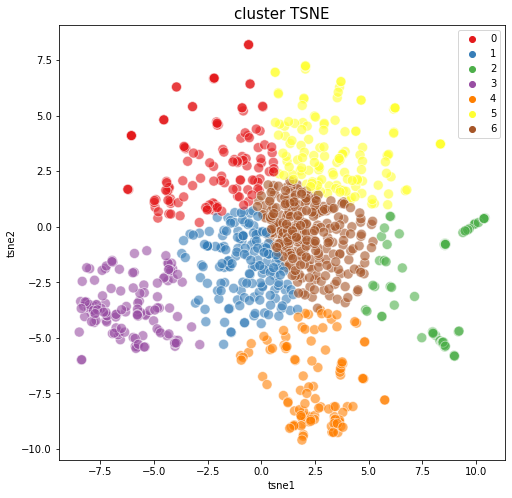

ARI: 0.304


In [9]:
#reduction PCA 80% variance expliquée 
#from sklearn.decomposition import PCA
#pca = PCA(n_components=0.8, random_state=42)
#pca.fit(df_VGG16)
#x = pca.transform(df_VGG16)

#reduction TSNE
tsne = TSNE(n_components=2, verbose=0, perplexity=80, n_iter=5000, learning_rate=200)
tsne = tsne.fit_transform(df_VGG16)
tsne_df = pd.DataFrame(tsne, columns=['tsne1', 'tsne2'])

#kmeans
kmeans = KMeans(n_clusters=7, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df)
labels = kmeans.labels_
clusters = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels})], axis=1)

#plot
plt.figure(figsize = (8,8))
sns.scatterplot(clusters.iloc[:,0],clusters.iloc[:,1],hue=labels, palette='Set1', s=100, alpha=0.6).set_title('cluster TSNE', fontsize=15)
plt.legend()
plt.show()

#ari
df_image['cluster_VGG16'] = labels
categories_true = df_image['cat_1']
categories_predict = df_image['cluster_VGG16']
from sklearn import metrics
ari_VGG16 = metrics.adjusted_rand_score(categories_true, categories_predict)
print("ARI: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))

In [10]:
df_image.groupby('cluster_VGG16')['cat_1'].value_counts().to_frame()

cat_1
cluster_VGG16 cat_1                            
0             Computers                      39
              Kitchen & Dining               36
              Home Decor & Festive Needs     33
              Home Furnishing                13
              Baby Care                       8
              Beauty and Personal Care        6
1             Computers                      76
              Home Decor & Festive Needs     25
              Kitchen & Dining               22
              Watches                        18
              Beauty and Personal Care       11
              Home Furnishing                 9
              Baby Care                       5
2             Kitchen & Dining               76
              Home Decor & Festive Needs      8
              Baby Care                       4
              Computers                       2
              Home Furnishing                 2
3             Watches                       130
              Home Decor & Festive Needs      2
4             Beauty and Personal Care      103
              Kitchen & Dining                7
              Baby Care                       2
              Computers                       2
              Home Decor & Festive Needs      1
5             Home Furnishing                71
              Baby Care                      50
              Beauty and Personal Care        9
              Home Decor & Festive Needs      6
6             Baby Care                      81
              Home Decor & Festive Needs     75
              Home Furnishing                55
              Computers                      31
              Beauty and Personal Care       21
              Kitchen & Dining                9
              Watches                         2

<AxesSubplot:xlabel='cluster_VGG16,cat_1'>

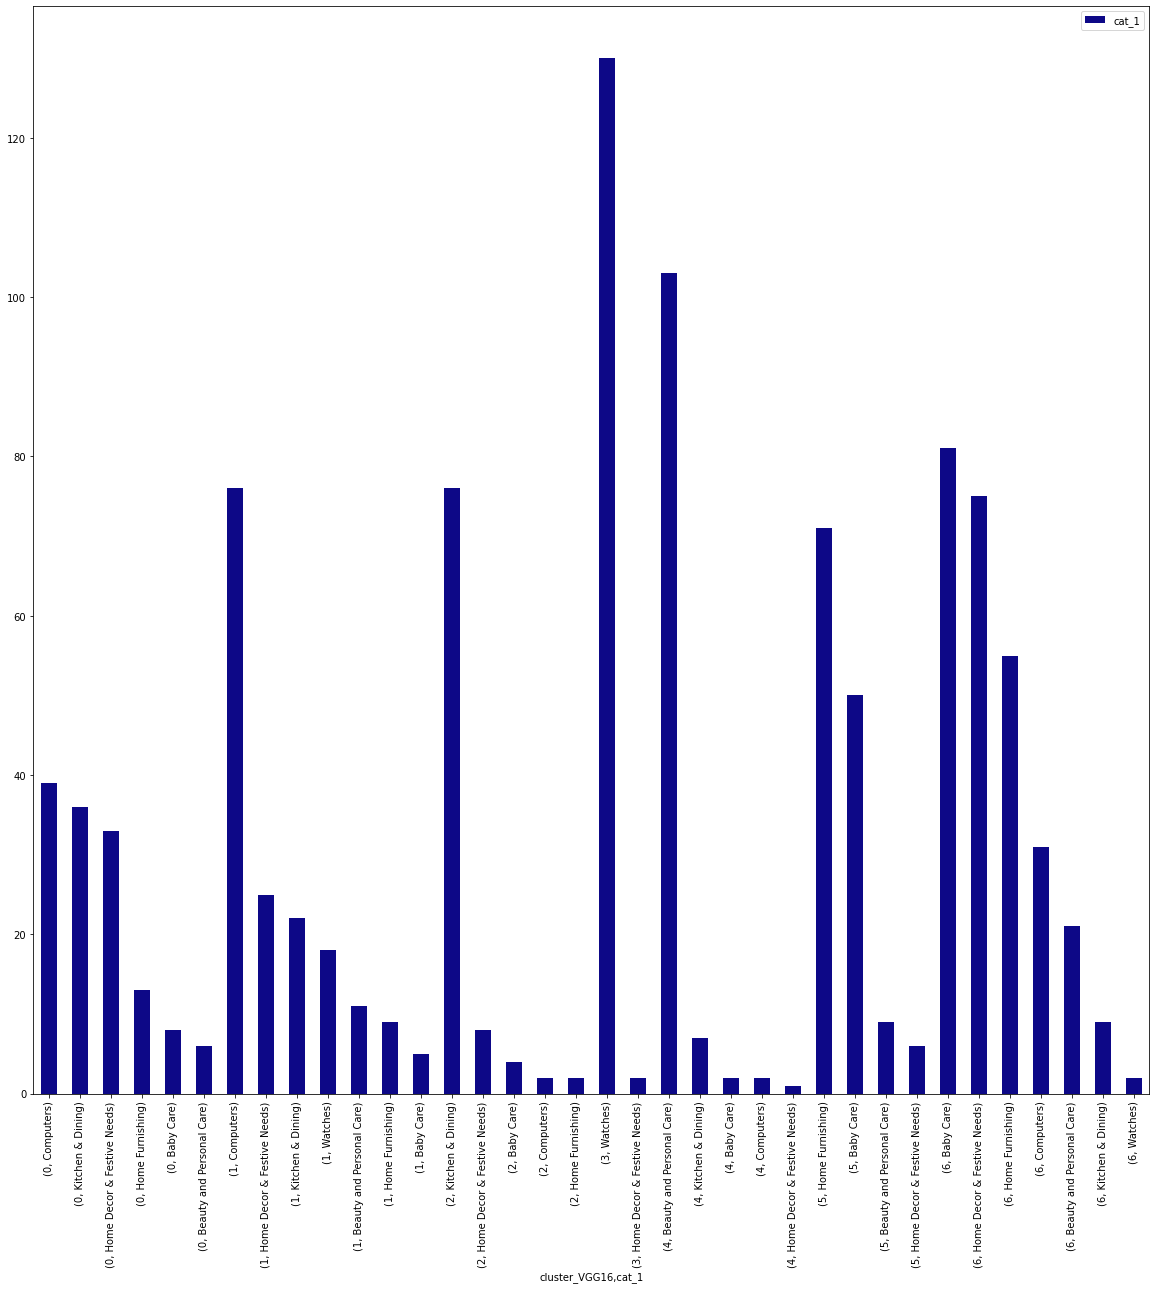

In [11]:
df_image.groupby('cluster_VGG16')['cat_1'].value_counts().to_frame().plot(kind='bar', figsize=(20,20),colormap='plasma')